<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/stock_prediction_using_LSTM_with_GA_ver2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Khai báo các thư viện cần thiết

In [96]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import LSTM, Dense # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

**Step 2**: Tiền xử lí dữ liệu

In [ ]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker, staperiod="10y", interval="1d"):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [ ]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("AAPL")


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-14,212.330002,213.940002,210.580002,212.429993,49325800.0
2025-05-15,211.449997,212.960007,209.539993,210.949997,45029500.0
2025-05-16,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-17,NaN,NaN,NaN,NaN,NaN
2025-05-18,NaN,NaN,NaN,NaN,NaN
2025-05-19,208.779999,209.479996,204.259995,207.910004,46140500.0
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0


In [ ]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

<ipython-input-89-9c6261708f8c>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-14,212.330002,213.940002,210.580002,212.429993,49325800.0
2025-05-15,211.449997,212.960007,209.539993,210.949997,45029500.0
2025-05-16,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-17,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-18,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-19,208.779999,209.479996,204.259995,207.910004,46140500.0
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0


In [ ]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,AAPL
Date,
2025-05-14,212.330002
2025-05-15,211.449997
2025-05-16,211.259995
2025-05-17,211.259995
2025-05-18,211.259995
2025-05-19,208.779999
2025-05-20,206.860001
2025-05-21,202.089996


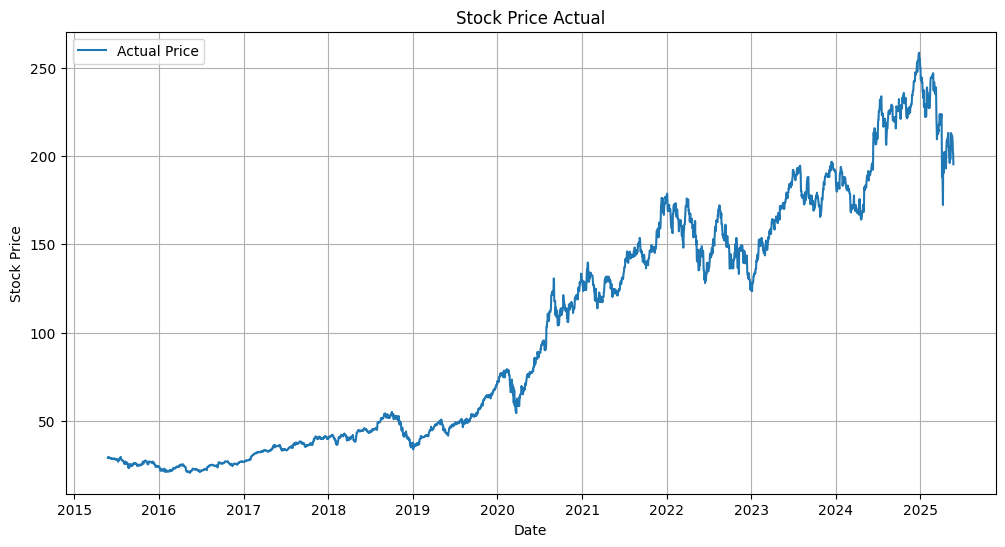

In [ ]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
scaler = MinMaxScaler() # chuẩn hóa dữ liệu
close_prices = data['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(close_prices)


**Step 3**: Implement LSTM

In [ ]:
# Lớp LSTM tùy chỉnh kế thừa từ tf.keras.layers.Layer
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units  # số lượng đơn vị ẩn (neurons)
        self.return_sequences = return_sequences  # có trả về toàn bộ chuỗi hay chỉ bước cuối

    def build(self, input_shape):
        self.input_dim = input_shape[-1]  # số chiều của đầu vào tại mỗi bước thời gian

        # Ma trận trọng số cho đầu vào x_t
        self.W_f = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_f")  # forget gate
        self.W_i = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_i")  # input gate
        self.W_c = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_c")  # candidate cell
        self.W_o = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_o")  # output gate

        # Ma trận trọng số cho trạng thái ẩn h_t
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_f")
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_i")
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_c")
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_o")

        # Các bias cho từng cổng
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", name="b_f")
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", name="b_i")
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", name="b_c")
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", name="b_o")

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]      # số lượng mẫu trong batch
        time_steps = inputs.shape[1]          # số bước thời gian (sequence length)
        h_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ẩn ban đầu h_0
        c_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ô nhớ ban đầu c_0
        outputs = []  # lưu tất cả hidden states theo thời gian

        # Duyệt qua từng bước thời gian
        for t in range(time_steps):
            x_t = inputs[:, t, :]  # lấy đầu vào tại thời điểm t

            # Tính toán các cổng
            f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_t, self.U_f) + self.b_f)  # cổng quên
            i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_t, self.U_i) + self.b_i)  # cổng đầu vào
            o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_t, self.U_o) + self.b_o)  # cổng đầu ra
            c_hat_t = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_t, self.U_c) + self.b_c)  # giá trị ô nhớ ứng viên

            # Cập nhật trạng thái ô nhớ và trạng thái ẩn
            c_t = f_t * c_t + i_t * c_hat_t  # công thức cập nhật trạng thái ô nhớ
            h_t = o_t * tf.tanh(c_t)         # công thức cập nhật trạng thái ẩn

            outputs.append(h_t)  # lưu trạng thái ẩn hiện tại

        # Kết quả có shape (batch_size, time_steps, units)
        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs            # trả về toàn bộ chuỗi các trạng thái ẩn
        else:
            return outputs[:, -1, :]  # chỉ trả về trạng thái ẩn cuối cùng (cuối chuỗi)


In [97]:
# Step 3: Build LSTM model
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(CustomLSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(CustomLSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 3.2**: Option sử dụng LSTM của thư viện (nhanh hơn) (không chạy đoạn code này khi đã chạy phần Step 3 và ngược lại)


In [ ]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 4**: Tối ưu hóa bằng GA

In [98]:
# Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

**Ý tưởng**: tối ưu bộ tham số (window_size, units) sử dụng GA với số thế hệ là 5, số cá thể của mỗi thế hệ là 30, tỉ lệ lai ghép: 0.8, tỉ lệ đột biến: 0.1. Không gian tìm kiếm: 180 * 4 = 720 (180 giá trị window_size, 4 giá trị units)
Chiến lược chọn thế hệ sau: Giữ lại 1 nửa thế hệ trước có fitness tốt nhất(15 cá thể), Chọn 2/3 cá thể tốt nhất ở thế hệ trước(20 cá thể) để chọn ngẫu nhiên trong đó 2 cá thể để lai ghép, sau đó cho cá thể con đột biến(nếu có). Lặp lại quá trình cho đến khi đủ số lượng cá thể(30 cá thể) cho thế hệ tiếp theo.

In [99]:
# Step 4: Genetic Algorithm for hyperparameter tuning
def genetic_algorithm(population_size=30, generations=5, mutation_rate=0.1, crossover_rate=0.8): # Các thông số trong GA
    # --------------------------
    # 1. Create a random individual
    def create_individual():
        return {
            'window_size': random.randint(30, 210), # Kích thước cửa sổ chọn từ 30 đến 90 ngày (có thể thay đổi)
            'units': random.choice([32, 64, 128, 256]) # Số units trên 1 lớp LSTM. Chọn các số này là vì GPU, TPU tính toán hiệu quả hơn với các giá trị unit là bội của 32
        }

    # --------------------------
    # 2. Evaluate fitness (lower MSE is better)
    def fitness(ind):
        X_win, y_win = create_dataset(scaled_data, ind['window_size'])
        #X_win, y_win = X_win[:-100], y_win[:-100]  # use training data # dùng phần đầu để train
        #X_val_gen, y_val_gen = X_win[-100:], y_win[-100:] # dùng 100 dữ liệu cuối để test
        split_index = int(len(X_win) * 0.8) # chia tập train - test là 80 - 20
        X_train_gen, y_train_gen = X_win[:split_index], y_win[:split_index]
        X_val_gen, y_val_gen = X_win[split_index:], y_win[split_index:]

        model = build_model((ind['window_size'], 1), units=ind['units']) # build model
        model.fit(X_train_gen, y_train_gen, epochs=3, batch_size=32, verbose=0) # huấn luyện mô hình
        preds = model.predict(X_val_gen) # dự đoán với dữ liệu test
        return mean_squared_error(y_val_gen, preds) # tính MSE (fitness định nghĩa ở đây thì cá thể có fitness càng nhỏ thì cá thể đó càng tốt)

    # --------------------------
    # 3. Selection: sort by fitness (elitism: top N)
    def selection(population, scores, num_elites=15):
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        return sorted_pop[:num_elites] # lấy trước 15 cá thể tốt nhất (fitness thấp nhất)

    # --------------------------
    # 4. Crossover: combine 2 parents into 1 child
    def crossover(parent1, parent2):
        if random.random() < crossover_rate: # nếu random ra < tỉ lệ lai ghép thì cho lai.
            return {
                'window_size': random.choice([parent1['window_size'], parent2['window_size']]),
                'units': random.choice([parent1['units'], parent2['units']])
            }
        else:
            # No crossover, just clone one of the parents(nếu ko thì ko làm gì)
            return random.choice([parent1, parent2]).copy()
    # --------------------------
    # 5. Mutation: randomly alter genes
    def mutate(ind):
        if random.random() < mutation_rate: # random ra nhỏ hơn tỉ lệ đột biến thì cho đột biến
            ind['window_size'] = random.randint(30, 210)
        if random.random() < mutation_rate:
            ind['units'] = random.choice([32, 64, 128, 256])
        return ind

    # --------------------------
    # 6. Replacement: create new generation from elites + offspring
    def create_next_generation(elites, population, size, scores):
        next_gen = elites[:]
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        while len(next_gen) < size:
            parent1, parent2 = random.sample(sorted_pop[:20], 2) # chọn 4 cá thể tốt nhất xong chọn 2 bố mẹ. Rồi tiến hành lai ghép, đột biến nếu có.
            child = crossover(parent1, parent2) # lai ghép
            child = mutate(child) # đột biến
            next_gen.append(child) # thêm vào thế hệ sau
        return next_gen

    # --------------------------
    # 7. Repeat over generations
    population = [create_individual() for _ in range(population_size)]
    best_individual = None
    best_score = float('inf')

    for gen in range(generations):
        print(f"\n Generation {gen+1}")
        scores = [fitness(ind) for ind in population]
        for i, (ind, score) in enumerate(zip(population, scores)):
            print(f"Individual {i+1}: window_size={ind['window_size']}, units={ind['units']}, MSE={score:.6f}")

        elites = selection(population, scores, num_elites=2)
        best_elite = elites[0]
        best_elite_score = scores[population.index(best_elite)]  # lấy đúng fitness đã tính
        print(f"Best individual of generation {gen+1}: window_size={best_elite['window_size']}, units={best_elite['units']}, MSE={best_elite_score:.6f}")

        if best_elite_score < best_score: # lấy cá thể tốt nhất trong tất cả những lần lai ghép
            best_score = best_elite_score
            best_individual = best_elite.copy()

        population = create_next_generation(elites, population, population_size, scores) # tạo thế hệ mới (gồm 15 cá thể tốt nhất của thế hệ trước và những cá thể khác được lai ghép, đột biến)

    print(f"\n Final best individual: window_size={best_individual['window_size']}, units={best_individual['units']}, MSE={best_score:.6f}")
    return best_individual

Step 5: Chạy thuật toán GA để tìm ra cá thể tốt nhất

In [2]:
# GA optimization
best_params = genetic_algorithm()
print("Best Parameters from GA:", best_params)

NameError: name 'genetic_algorithm' is not defined

**Step 6**: Huấn luyện và tính RMSE đối với cá thể tốt nhất được chọn

In [ ]:
# Final model training and evaluation
X_final, y_final = create_dataset(scaled_data, best_params['window_size'])
split_index = int(len(X_final) * 0.8) # chia tập train - test là 80 - 20
X_train_final, y_train_final = X_final[:split_index], y_final[:split_index]
X_test, y_test = X_final[split_index:], y_final[split_index:]


model = build_model((best_params['window_size'], 1), best_params['units'])
model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, verbose=1)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Test RMSE:", rmse)

<ipython-input-53-82c27d96973a>:5: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 108ms/step - loss: 0.0177
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 1.0608e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 1.0930e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 9.5866e-05
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 9.8708e-05
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 9.5747e-05
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 1.0361e-04
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 1.1116e-04
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 9.5959e-05
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 8.9527e-05
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step
Test RMSE: 0.01866035109878875


**Đồ thị tập train**

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


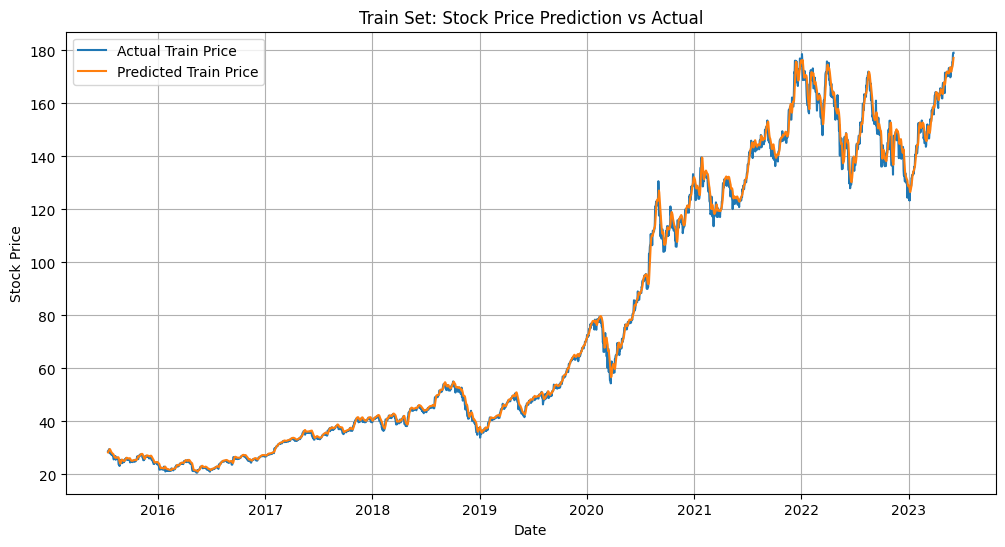

In [ ]:
train_preds = model.predict(X_train_final)
# Inverse transform để đưa dữ liệu về giá gốc
y_train_rescaled = scaler.inverse_transform(y_train_final)
train_preds_rescaled = scaler.inverse_transform(train_preds)

# Lấy index ngày tương ứng (trừ đi window_size vì input có độ trễ)
train_dates = data.index[best_params['window_size']:best_params['window_size'] + len(y_train_final)]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train_rescaled, label='Actual Train Price')
plt.plot(train_dates, train_preds_rescaled, label='Predicted Train Price')
plt.title('Train Set: Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 7**: Vẽ đồ thị tập test

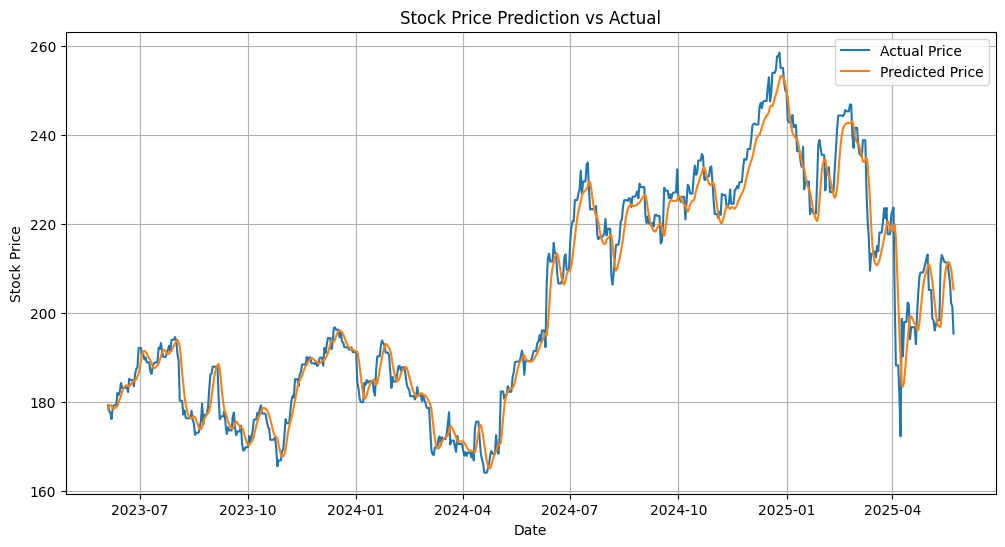

In [ ]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price')
plt.plot(dates, preds_rescaled, label='Predicted Price')
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 8**: Vẽ đồ thị 100 ngày gần nhất

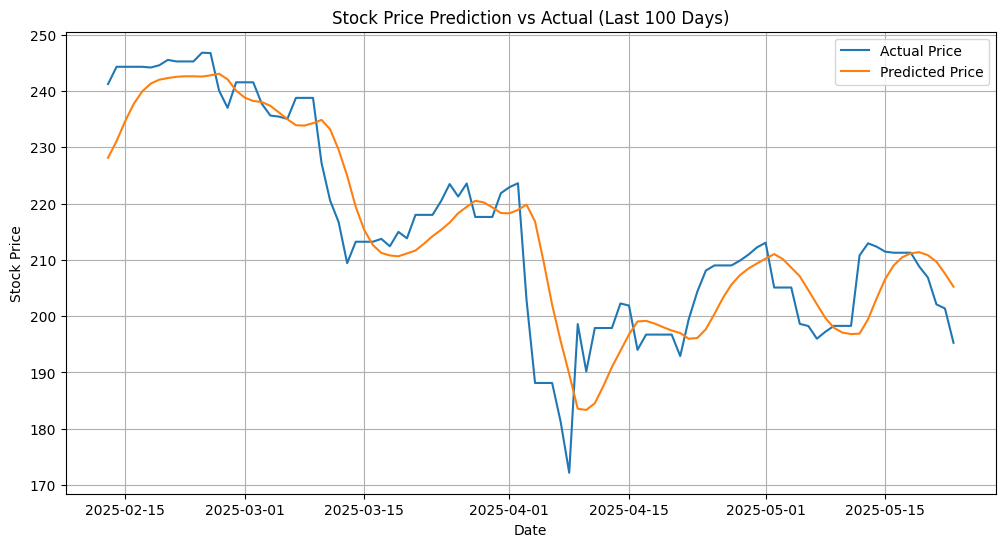

In [ ]:
# Chỉ lấy 100 mẫu cuối cùng
num_plot = 100
y_test_subset = y_test[-num_plot:]
preds_subset = preds[-num_plot:]

# Biến đổi ngược lại giá gốc
y_test_rescaled = scaler.inverse_transform(y_test_subset)
preds_rescaled = scaler.inverse_transform(preds_subset)

# Lấy đúng 100 ngày cuối tương ứng trong dữ liệu gốc
dates = data.index[-num_plot:]

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price')
plt.plot(dates, preds_rescaled, label='Predicted Price')
plt.title('Stock Price Prediction vs Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


Thêm vòng for để chạy từng mã cổ phiếu. AE test hiệu năng ở phần trên đã thấy oke thì mới chạy cái này nhé. Thời gian chạy x loại cổ phiếu bằng x lần thời gian chạy 1 cổ phiếu :((

**Step 9:** Dự đoán giá những ngày sau đó (Chưa có dữ liệu thực)



In [ ]:
import pandas as pd
import numpy as np

def predict_next_days(model, last_sequence, days_to_predict=30, scaler=None):
    """
    Dự đoán `days_to_predict` ngày tiếp theo dựa vào chuỗi đầu vào `last_sequence`.
    Trả về danh sách các giá trị thực tế (đã inverse_transform nếu cần).
    """
    predicted = []
    current_input = last_sequence.reshape(1, last_sequence.shape[0], 1)

    for _ in range(days_to_predict):
        next_price = model.predict(current_input, verbose=0)[0][0]
        predicted.append(next_price)
        current_input = np.append(current_input[:, 1:, :], [[[next_price]]], axis=1)

    if scaler:
        predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()

    return predicted


In [ ]:
# Lấy ngày cuối cùng trong dữ liệu yfinance
last_date = data.index[-1]

# Tạo 30 ngày làm việc tiếp theo (bỏ cuối tuần)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)


In [ ]:
# Lấy chuỗi gần nhất
last_sequence = scaled_data[-best_params['window_size']:]

# Dự đoán 30 ngày tới
predicted_prices = predict_next_days(model, last_sequence, days_to_predict=30, scaler=scaler)

# In kết quả theo ngày
for date, price in zip(future_dates, predicted_prices):
    print(f"{date.strftime('%Y-%m-%d')}: {price:.2f}")


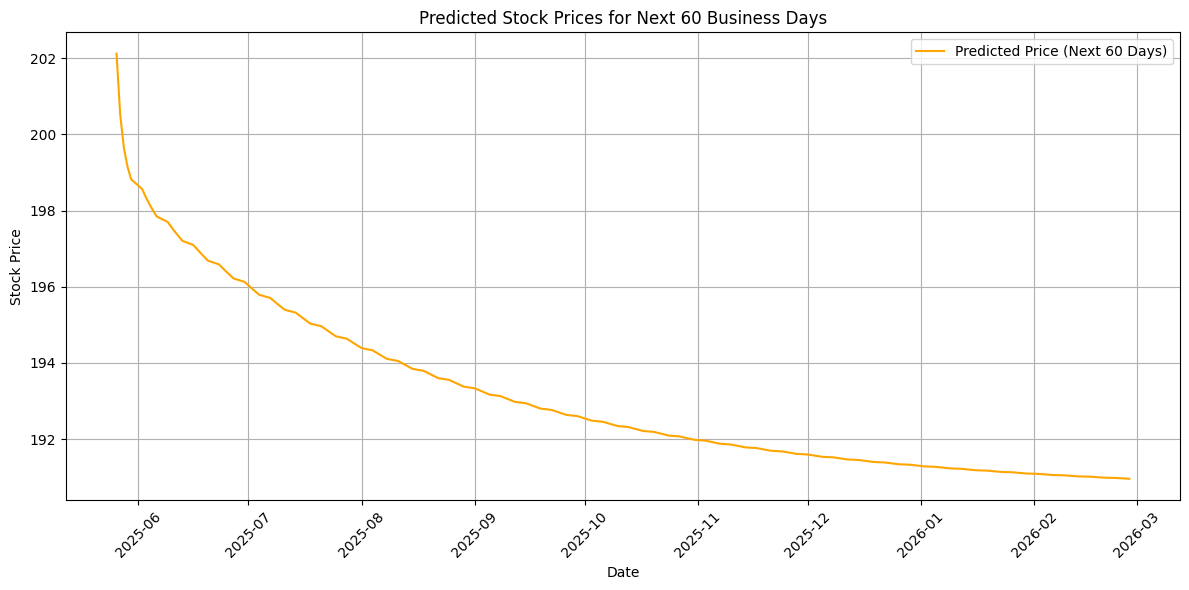

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predicted_prices, label='Predicted Price (Next 60 Days)', color='orange')
plt.title('Predicted Stock Prices for Next 60 Business Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Step 10**: Thêm vòng for để dự đoán nhiều loại cổ phiếu (Code y như phần dự đoán 1 cổ phiếu chỉ thêm vòng for)

In [ ]:
symbols = ["AAPL", "GOOG", "MSFT", "AMZN"]

In [ ]:
for symbol in symbols:
    print(f"\n========= Processing {symbol} =========")

    # code này y như phần trên
    data = download_stock_data(symbol)
    data = data.asfreq('D')
    data = data.fillna(method='ffill')
    scaler = MinMaxScaler()
    close_prices = data['Close'].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(close_prices)

    best_params = genetic_algorithm()
    print("Best Parameters from GA:", best_params)

    X_final, y_final = create_dataset(scaled_data, best_params['window_size'])
    split_index = int(len(X_final) * 0.8)
    X_train_final, y_train_final = X_final[:split_index], y_final[:split_index]
    X_test, y_test = X_final[split_index:], y_final[split_index:]

    model = build_model((best_params['window_size'], 1), best_params['units'])
    model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, verbose=1)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Test RMSE:", rmse)

    y_test_rescaled = scaler.inverse_transform(y_test)
    preds_rescaled = scaler.inverse_transform(preds)
    dates = data.index[-len(y_test):]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_rescaled, label='Actual Price')
    plt.plot(dates, preds_rescaled, label='Predicted Price')
    plt.title(f'{symbol} Stock Price Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
